In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import pandas_ta as pta
from yahoo_fin import stock_info as si
import seaborn as sns

/Users/yashsolanki/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [429]:
stocks = ['ITC.NS', "LT.NS", "AXISBANK.NS"]
TOTAL_DAYS = 252
close_prices = []
for i in range(len(stocks)):
    df = si.get_data(stocks[i])
    close_vals = df['close'].to_list()
    close_vals = close_vals[len(close_vals) - TOTAL_DAYS: len(close_vals)]
    close_prices.append(close_vals)
    close_vals = []
    
close_prices = np.array(close_prices).T


In [430]:
portfolio_df = pd.DataFrame(close_prices, columns=[i for i in stocks])

In [431]:
portfolio_df.head()

,ITC.NS,LT.NS,AXISBANK.NS
0,274.799988,1640.199951,672.200012
1,273.899994,1589.449951,665.849976
2,267.899994,1584.550049,658.599976
3,270.850006,1595.099976,661.299988
4,270.149994,1585.099976,660.700012


## Getting the covariance matrix and the log returns of the portfolio

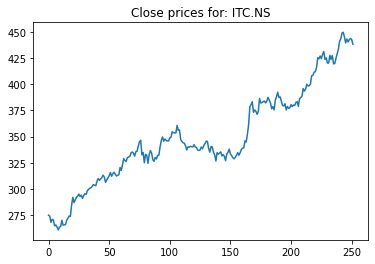

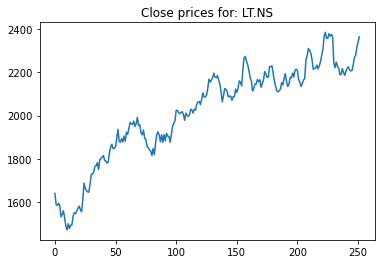

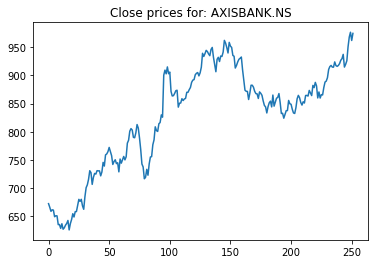

In [432]:
for i in portfolio_df.columns:
    plt.plot(portfolio_df[i])
    plt.title(f"Close prices for: {i}")
    plt.show()

In [433]:
log_returns = []
for i in portfolio_df.columns:
    stock_log_returns = np.log(portfolio_df[i]/portfolio_df[i].shift(1)).dropna().to_list()
    log_returns.append(stock_log_returns)

log_returns = np.array(log_returns).T
log_returns = pd.DataFrame(log_returns, columns=[i for i in portfolio_df.columns])
log_returns.mean() * 252


/Users/yashsolanki/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning:

invalid value encountered in log



ITC.NS         0.469064
LT.NS          0.366568
AXISBANK.NS    0.373106
dtype: float64

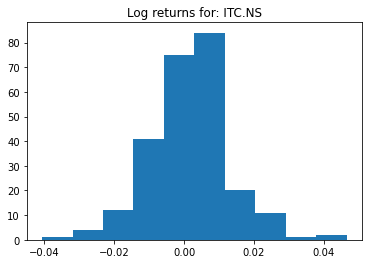

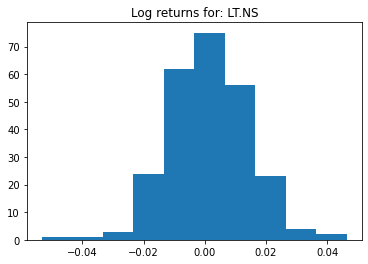

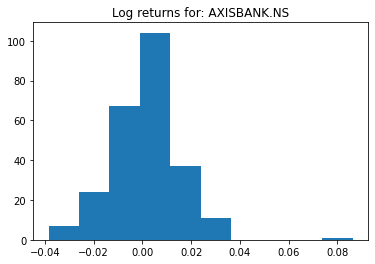

In [434]:
for i in log_returns.columns:
    plt.hist(log_returns[i])
    plt.title(f"Log returns for: {i}")
    plt.show()

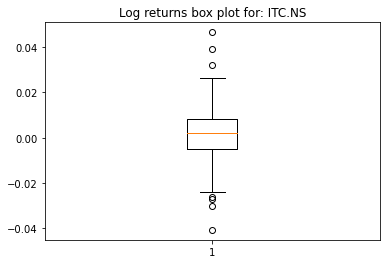

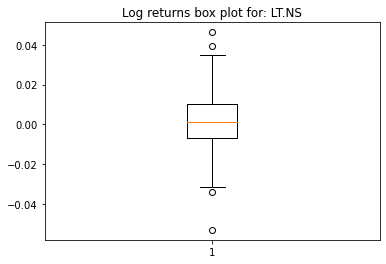

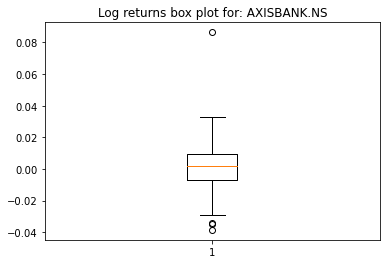

In [435]:
for i in log_returns.columns:
    plt.boxplot(log_returns[i])
    plt.title(f"Log returns box plot for: {i}")
    plt.show()

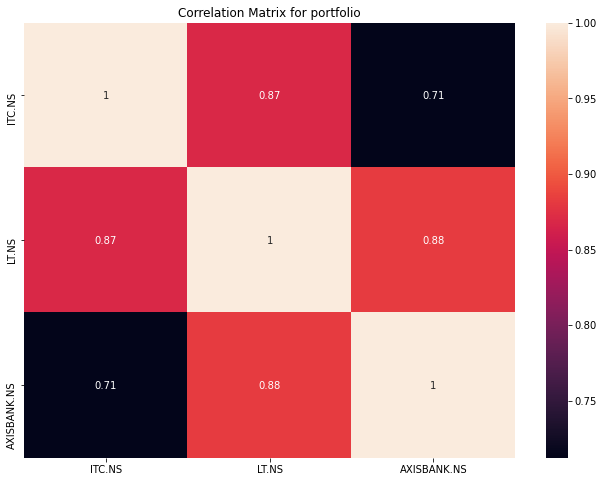

In [436]:
correlation_matrix = portfolio_df.corr()
fig = plt.figure(figsize=[11, 8])
ax = sns.heatmap(correlation_matrix, annot=True)
plt.title("Correlation Matrix for portfolio")
plt.show()

## Calculation of volitality over a certain number of trading days 
Here the sqrt of the number of days is used because std is the square root of the variance and variance is generally proportional to time.

In [437]:
TRADING_DAYS = 60
close_prices_df = pd.DataFrame(close_prices, columns=[i for i in stocks])
# volitality = close_prices_df.rolling(TRADING_DAYS).std() * np.sqrt(TRADING_DAYS) (Use this with pct_change if not using logs)
volitality = log_returns.rolling(TRADING_DAYS).std() * np.sqrt(TRADING_DAYS)

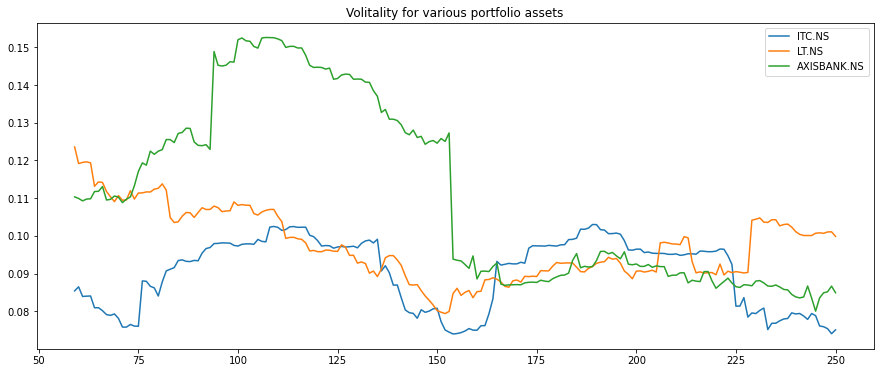

In [438]:
# for i in volitality.columns:
#     fig = plt.figure(figsize=(15, 4))
#     plt.plot(volitality[i])
#     plt.title(f"Volitality of {i} over {TRADING_DAYS} days as per returns")
#     plt.show()

volitality.plot(figsize=(15, 6))
plt.title("Volitality for various portfolio assets")
plt.show()

In [439]:
risk_free_return = 0

In [440]:
sharpe_ratio = (log_returns.rolling(TRADING_DAYS).mean() - risk_free_return) / volitality

# Annualized sharpe ratio = daily sharpe ratio * sqrt(total_days)
annualized_sharpe_ratio = ((log_returns.mean() - risk_free_return) / log_returns.std()) * np.sqrt(TOTAL_DAYS)

In [441]:
print("Annualized Sharpe ratio for the stocks in the portfolio")
for i in range(len(annualized_sharpe_ratio)):
    print(f"{stocks[i]} has a annualized sharpe ratio of: {annualized_sharpe_ratio[i]}")

Annualized Sharpe ratio for the stocks in the portfolio
ITC.NS has a annualized sharpe ratio of: 2.559250810080594
LT.NS has a annualized sharpe ratio of: 1.7468198201335428
AXISBANK.NS has a annualized sharpe ratio of: 1.6619834992323557


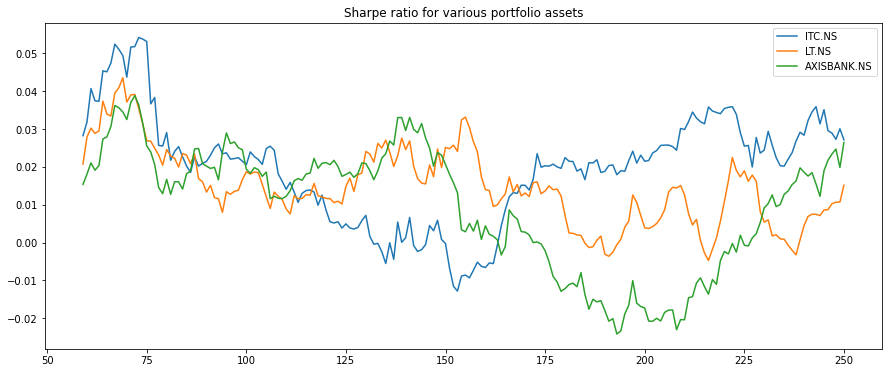

In [442]:
# for i in sharpe_ratio.columns:
#     fig = plt.figure(figsize=(15, 4))
#     plt.plot(sharpe_ratio[i])
#     plt.title(f"Sharpe ratio of {i} over {TRADING_DAYS} days as the len of mean")
#     plt.show()

sharpe_ratio.plot(figsize=(15, 6))
plt.title("Sharpe ratio for various portfolio assets")
plt.show()

## Calculation of the sortino ratio for the individual stocks of the portfolio

In [443]:
downside_volitality = log_returns[log_returns < 0].rolling(TRADING_DAYS, center=True, min_periods=10).std() * np.sqrt(TRADING_DAYS)
sortino_ratio = (log_returns.rolling(TRADING_DAYS).mean() - risk_free_return) / downside_volitality
annualized_sortino_ratio = ((log_returns.mean() - risk_free_return) / downside_volitality.std()) * np.sqrt(TOTAL_DAYS)

In [444]:
print("Annualized Sortino ratio for the stocks in the portfolio")
for i in range(len(annualized_sortino_ratio)):
    print(f"{stocks[i]} has a annualized Sortino ratio of: {annualized_sharpe_ratio[i]}")

Annualized Sortino ratio for the stocks in the portfolio
ITC.NS has a annualized Sortino ratio of: 2.559250810080594
LT.NS has a annualized Sortino ratio of: 1.7468198201335428
AXISBANK.NS has a annualized Sortino ratio of: 1.6619834992323557


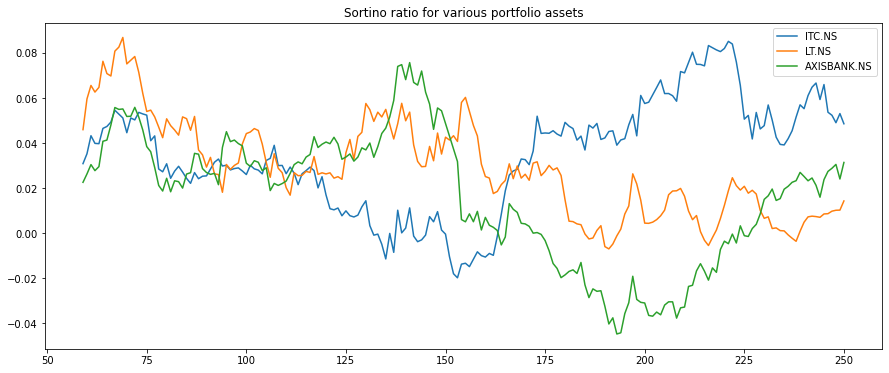

In [445]:
# for i in sortino_ratio.columns:
#     fig = plt.figure(figsize=(15, 4))
#     plt.plot(sortino_ratio[i])
#     plt.title(f"Sortino ratio of {i} over {TRADING_DAYS} days as the len of mean")
#     plt.show()


sortino_ratio.plot(figsize=(15, 6))
plt.title("Sortino ratio for various portfolio assets")
plt.show()

## Calculating the M2 ratio 

In [446]:
BENCHMARK = stocks[0]
benchmark_volitality = volitality[BENCHMARK]
m2_ratios = pd.DataFrame()
for i in log_returns.columns:
    if i != BENCHMARK:
        m2_ratio = sharpe_ratio[i] * benchmark_volitality + risk_free_return
        m2_ratios[i] = m2_ratio


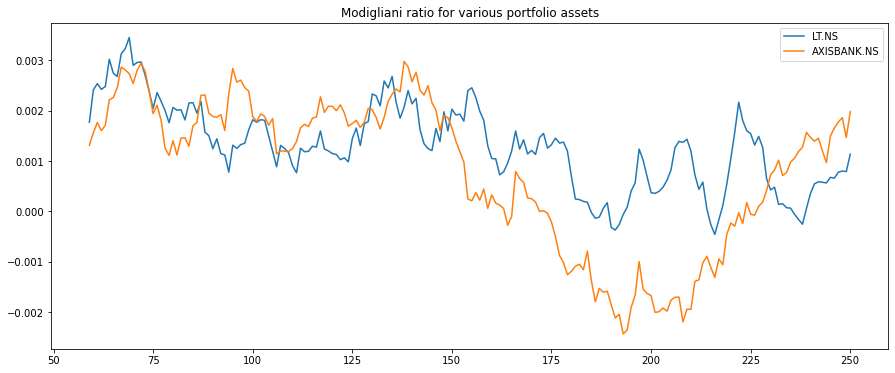

In [447]:
m2_ratios.plot(figsize=(15, 6))
plt.title("Modigliani ratio for various portfolio assets")
plt.show()

## Calculating the Efficient Frontier in order to determine portfolio weightings for diversification

In [448]:
# Equations and inituition from https://www.machinelearningplus.com/machine-learning/portfolio-optimization-python-example/#variance

# This cell is simply a test cell for experiments based of the efficient frontier calculation steps
# num_assets = len(stocks)
# mean_returns = log_returns.mean()
# covariance_matrix = log_returns.cov()
# portfolio_weights = np.array([0, 0.1])
# expected_return = np.dot(mean_returns, portfolio_weights)
# portfolio_std = np.sqrt(np.dot(portfolio_weights.T, np.dot(covariance_matrix, portfolio_weights)))*np.sqrt(252)
# print(f"Portfolio std deviation: {portfolio_std}")

num_assets = len(stocks)
mean_returns = log_returns.mean()
covariance_matrix = log_returns.cov()


In [449]:
portfolio_weights = []
portfolio_returns = []
portfolio_volitality = []

# returns_n = portfolio_df.pct_change()
covariance_matrix = log_returns.cov()
num_portfolios = 1000
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights / np.sum(weights) # Ensure that the weights sum up to one
    portfolio_weights.append(weights)
    # Use portfolio expected return formula 
    mean_returns = log_returns.mean()
    returns = np.dot(mean_returns, weights)
    portfolio_returns.append(returns)
    portfolio_volitality.append(np.sqrt(
        np.dot(weights.T, np.dot(log_returns.cov() * 252, weights.T))))
    
data = {'Returns': portfolio_returns, 'Volatility': portfolio_volitality}
for counter, symbol in enumerate(portfolio_df.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in portfolio_weights]

portfolios = pd.DataFrame(data)
portfolios




,Returns,Volatility,ITC.NS weight,LT.NS weight,AXISBANK.NS weight
0,0.001497,0.208892,0.046777,0.043954,0.909269
1,0.001556,0.152330,0.228559,0.458762,0.312680
2,0.001697,0.153695,0.569697,0.022428,0.407874
3,0.001614,0.145475,0.368879,0.284942,0.346178
4,0.001582,0.150126,0.299814,0.475879,0.224307
...,...,...,...,...,...
995,0.001553,0.152597,0.218619,0.430529,0.350852
996,0.001669,0.156172,0.526379,0.469608,0.004013
997,0.001645,0.149770,0.441181,0.126745,0.432074
998,0.001602,0.163517,0.323572,0.079286,0.597142


In [450]:
min_volitality_portfolio = min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
print(min_volitality_portfolio)
max_sharpe_ratio_portfolio = portfolios.iloc[((portfolios['Returns']-risk_free_return)/portfolios['Volatility']).idxmax()]
print(max_sharpe_ratio_portfolio)


Returns               0.001648
Volatility            0.143617
ITC.NS weight         0.459785
LT.NS weight          0.277745
AXISBANK.NS weight    0.262471
Name: 751, dtype: float64
Returns               0.001689
Volatility            0.145210
ITC.NS weight         0.563485
LT.NS weight          0.227535
AXISBANK.NS weight    0.208980
Name: 585, dtype: float64


In [451]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

portfolios_scatter = go.Scatter(x=portfolios['Volatility'] * 100, y=portfolios['Returns'] * 100, mode='markers', name='Portfolios along efficient frontier')
min_volitality_portfolio_scatter = go.Scatter(
    x=[min_volitality_portfolio[1] * 100], y=[min_volitality_portfolio[0] * 100], marker=dict(color='red', size=14, line=dict(width=3, color='black')), 
    name='Minimum Volitality Portfolio')

max_sharpe_ratio_portfolio_scatter = go.Scatter(
    x=[max_sharpe_ratio_portfolio[1] * 100], y=[max_sharpe_ratio_portfolio[0] * 100], marker=dict(color='green', size=14, line=dict(width=3, color='black')), 
    name='Maximum Sharpe Ratio Portfolio')

data = [portfolios_scatter, min_volitality_portfolio_scatter,
        max_sharpe_ratio_portfolio_scatter]
layout = go.Layout(
    title='Portfolio Optimisation with the Efficient Frontier',
    yaxis=dict(title='Annualised Return (%)'),
    xaxis=dict(title='Annualised Volatility (%)'),
    showlegend=True,
    legend=dict(
        x=0.75, y=0, traceorder='normal',
        bgcolor='#E2E2E2',
        bordercolor='black',
        borderwidth=2),
    width=800,
    height=600)
fig = go.Figure(data=data, layout=layout)
fig.show()


In [452]:
portfolios

,Returns,Volatility,ITC.NS weight,LT.NS weight,AXISBANK.NS weight
0,0.001497,0.208892,0.046777,0.043954,0.909269
1,0.001556,0.152330,0.228559,0.458762,0.312680
2,0.001697,0.153695,0.569697,0.022428,0.407874
3,0.001614,0.145475,0.368879,0.284942,0.346178
4,0.001582,0.150126,0.299814,0.475879,0.224307
...,...,...,...,...,...
995,0.001553,0.152597,0.218619,0.430529,0.350852
996,0.001669,0.156172,0.526379,0.469608,0.004013
997,0.001645,0.149770,0.441181,0.126745,0.432074
998,0.001602,0.163517,0.323572,0.079286,0.597142
